## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random

%matplotlib inline
from IPython.display import clear_output
import os
import sys
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

In [4]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text)) + ['/']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Генерация по абзацам (параграф на обучение)

попробуем сформировать батчи, используя абзацы текста шекспира

In [8]:
text_paragraphs = list(map(lambda x: x.strip(), text.split('\n')))

In [9]:
paragraphs = []
paragraph = []
for line in text_paragraphs:
    if len(line) > 0:
        paragraph.append(line)
    else:
        if len(paragraph) > 1:
            paragraphs.append(paragraph)
        paragraph = []
        
paragraphs = list(map(lambda x: '\n '.join(x),paragraphs))

#### Рапределение длин абзацов по символьная

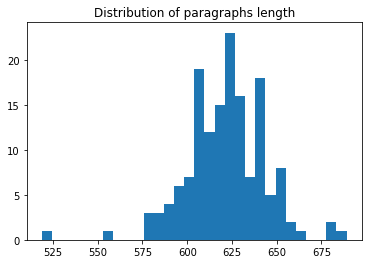

In [10]:
plt.title("Distribution of paragraphs length")
plt.hist(list(map(len,paragraphs)), bins = 30);

In [14]:
class RNN_gen(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=5, hidden_size=64, num_layers = 1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers = num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, h_prev = None):
        h_seq, h_next = self.rnn(self.emb(x),h_prev)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, h_next

In [15]:
def to_matrix(names, max_len=None, pad=token_to_idx['/'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

#### Pretraining

In [16]:
batch_ix = to_matrix([paragraphs[x] for x in random.sample(range(0, len(paragraphs)), 5)])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

model = RNN_gen()
criterion = nn.NLLLoss()
logp_seq, _ = model(batch_ix)
loss = criterion(logp_seq[:, :-1].contiguous().view(-1, len(tokens)),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()
loss

tensor(3.6527, grad_fn=<NllLossBackward>)

In [17]:
MAX_LENGTH = 600
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64).to(device)
    hid_state = None
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out[-1, :, :] / temperature, dim=-1).cpu().data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        next_ix.unsqueeze_(2)
        
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)

    return ''.join([idx_to_token[ix] for ix in x_sequence.cpu().data.numpy()[0][0]])

love the proud a finders would the strange thy shall stay,
 and shall not still where i surfer, the strange mine own should be thy beauty,
 and there is the sovery of the read,
 that shall i love thou art for my compless'd the bear beauty be to be and me of the world to be and beauty still,
 the world to be thy consence doth prove the verse thee that is and see the grownon the well,
 the condering so the strong do not seem the with the wilts with thy sing,
 and then the world to thee to the strange thy sing,
 and therefore is thy sweet seem the world to thee that shall not still the surfer sti


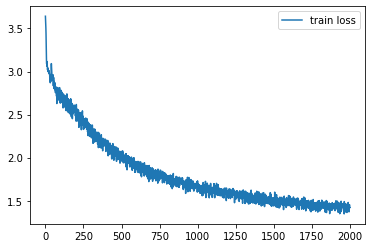

In [18]:
MAX_LENGTH = max(map(len,paragraphs))

model = RNN_gen(hidden_size = 200).to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())

history = []
for i in range(2000):
    batch_ix = to_matrix([paragraphs[x] for x in random.sample(range(0, len(paragraphs)), 16)])
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    #loss = # YOUR CODE HERE
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i+1)%40==0:
        clear_output(True)
        with torch.no_grad():
            print(generate_sample(model, seed_phrase='love ', temperature=0.3))
        plt.plot(history,label='train loss')
        plt.legend()
        plt.show()
        
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [19]:
print(generate_sample(model, seed_phrase='i', temperature=0.3))

ing the bear state,
 and there both shame i be see not speed shall stay,
 when i be thy single of the gaints are breast,
 so thou that the will be state,
 and then that i have steet so shall be thy sweet see the canst the world the thing me things the world the strange thee that i conder that i do be in grace of the seembl'd the beath the world to shor mence and sing,
 and there all the strange my love the streagut of the waster and from the strange mine eyes for the beauty's purt,
 and then thou art the strange thee,
 and beauty stand,
 though the will in thee thy sage, that i preast to the w


In [20]:
print(generate_sample(model, seed_phrase='i', temperature=1.6))

if thoughtst spienl,
-'denrt puchlyawite
 buiq stort modens'mwars wo i, wherelorn evreat'ss an et'cbl'gloed.
 o! wanlil't.
 hes wrac
 s,arloose bly uight to grac.
 o! imitb my jinjuyisy, and qefatye
 why towest, anmuetald brint;
 and thusla-tio! he tvy denrud i, jys?
 whetriek mm, ler,
 infam!anil, haccowy?
 ipage; not sqnes:
 rink dayc?
,
 kame kor, teing! dost,
 rmmse shal! be civedt stavery is otire,
 seaun, equer lairesw touds.
 then i hlave, racrur mecamis,
 an hem hawting to lpel
 mo nonfw?hey a yyow'gin nixale!
 shoudh murlucs befum;, and daind with not:k;
 low'-tlricire hast?/ 'occile 


#### Попробуем увеличить числи слоев в RNN

love is must eyes thy form that is so fair alone:
 their incels,
 be stope.
 o! now thy death,
 as thou shouldst thou thy sake;
 feet strengthen's pride,
 so love her fead sim for conscires, and all this tor they see as thy books graces have i amsem man age,
 the mark head truth to show it not seem love stont./////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


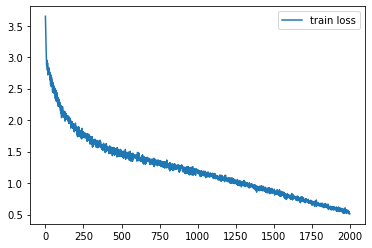

In [21]:
MAX_LENGTH = max(map(len,paragraphs))

model = RNN_gen(hidden_size = 200, num_layers = 3).to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())

history = []
for i in range(2000):
    batch_ix = to_matrix([paragraphs[x] for x in random.sample(range(0, len(paragraphs)), 16)])
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    #loss = # YOUR CODE HERE
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i+1)%40==0:
        clear_output(True)
        with torch.no_grad():
            print(generate_sample(model, seed_phrase='love ', temperature=0.3))
        plt.plot(history,label='train loss')
        plt.legend()
        plt.show()
        
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [22]:
print(generate_sample(model, seed_phrase='i', temperature=0.3))

if thy soul that i const it to my were on the suncrence is enver true this,
 and like our love sail, she store,
 when in my fair fair heart trust;
 end feastr of surveating evrure.
 love, and they, as find romp,
 prove thres are parture too should in thine eye,
 and in thee
 to grief
 to bear that in another time's fair shall be the praise thee, if earing still,
 and see thy fair new.
 reaght, that mine eye a swondating stand,
 stealing a fair hath my addel sun't my believe thou art the dead name will be the stard
 of true time with my love's fresh ornerit it now see again, and do i not sweet 


In [26]:
print(generate_sample(model, seed_phrase='i', temperature=1.6))

it it nor through i, and crow?
 widnd not be,
 and legkhs kings,
 add'st thou knobm wrom'd and to eightm overnse uphert no, be hence.
 o! unjus:
 hy arvow hymcainst take should dear found.
 if receive to-th?our;
 werchosured: phy inkicftakind'es abife impre's dire aloneen;
 ?or eene beauty's hath, and umbain doth alone:
 thy bowourixst my eltcying outwast! my lovers use't not emen thlust, well stain who soone.///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [27]:
class LSTM_gen(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=5, hidden_size=64, num_layers = 1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, hidden_size, batch_first=True, num_layers  = num_layers)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, h_prev = None):
        h_seq, h_next = self.rnn(self.emb(x),h_prev)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, h_next

love ent where thou thee, and there be of your pain,
 the stores of the to beauty should and day,
 that i see thou make the live the warter pair,
 and loves and heart the strong tongues to be.
 in the sweet of my heart that thine eyes wite,
 that thou art the read the winder the dight,
 and therefore but i seep and the say be.
 the care the connual have in the dook sad,
 whilst thou thy self dost the strely gill'd,
 the eact mase be the will of the ware,
 and somethes fresers with the strong thine,
 the war when i have and of the deast thee,
 where i the will worth, the love the pair thou trut


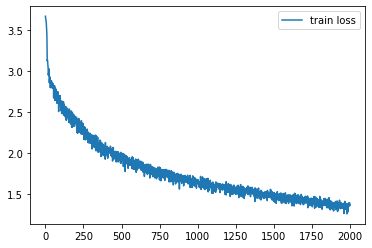

In [28]:
MAX_LENGTH = max(map(len,paragraphs))

model = LSTM_gen(hidden_size = 200).to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())

history = []
for i in range(2000):
    batch_ix = to_matrix([paragraphs[x] for x in random.sample(range(0, len(paragraphs)), 16)])
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    #loss = # YOUR CODE HERE
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i+1)%40==0:
        clear_output(True)
        with torch.no_grad():
            print(generate_sample(model, seed_phrase='love ', temperature=0.3))
        plt.plot(history,label='train loss')
        plt.legend()
        plt.show()
        
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [29]:
print(generate_sample(model, seed_phrase='me', temperature=0.3))

me all the such that the waster and still,
 and thou art some in the to be or me,
 the will my love, thou worth the wrom thee store,
 when i be oft so all the strength are dear;
 the world so doth such that with thee then the connute,
 and the streng that the strely gare thee state,
 the range my love, i war for my stant,
 and this beauty of the strong to thee./////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


In [30]:
print(generate_sample(model, seed_phrase='me', temperature=1.6))

me, iw,h and petarsn,, i onncayue 'wrt's
 tawe, st ayisubcold derage love:
 soil yought faon i haty'lear of yeir,
 ere/ ondvendouts'd aly,e wesid?ies;
 in meath,, vyitmer, anpewh-gr ahjebfere muy,
 whicr poild as hid my pald one?'roinc higcre.
 swinls i kmliok'ds witilauty! nor to egpa'l by-nst?
 to bis ro nate ede de'ty., anow gdeesst
 khoping sweeit sid'',;'xptpepmicediess kefpiga;''.
 hackont by need, felj showls, and me; expime hiat:,
 direhit spill; 'xrf-bead'st nowarn roudd'n spice) olt:
 now till pam! mich now,is, kn'eaccetstow trt:
-sr romrs-mir in the geace pruerifouls leelr
 tit ring


#### Попробуем увеличить число слоев в LSTM

love is my verse as the seees
 decease, to be is it not so;
 to well in the stars to endoure of the seem,
 which i will not show it is not so deeming;
 then then make me so thee three of theeest
 is in the face praise of soung of his seen,
 though i snow not self dost beauty to the staring,
 when thou art assising against the still when the oftar disage:
 then mine eye i hasted be asel be than a from thee,
 who like a save thee me my self diseate./////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


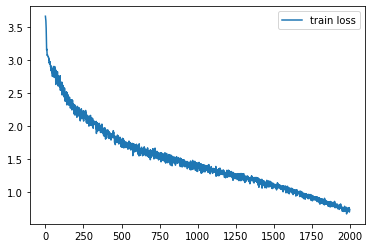

In [31]:
MAX_LENGTH = max(map(len,paragraphs))

model = LSTM_gen(hidden_size = 200, num_layers = 3).to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())

history = []
for i in range(2000):
    batch_ix = to_matrix([paragraphs[x] for x in random.sample(range(0, len(paragraphs)), 16)])
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    #loss = # YOUR CODE HERE
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i+1)%40==0:
        clear_output(True)
        with torch.no_grad():
            print(generate_sample(model, seed_phrase='love ', temperature=0.3))
        plt.plot(history,label='train loss')
        plt.legend()
        plt.show()
        
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [32]:
print(generate_sample(model, seed_phrase='me', temperature=0.3))

me say thy most thou say to sear you dost stay
 were you with thee world thy shadow of youth,
 and all my brast that that so thine eyes doth clear;
 and i make me well as a from thee,
 that i have stand i say the some one wanting set,
 and praise them my mistress' eyes worth they shalt dearty;
 thereed, and in my sound mad ware waste;
 nor sweetled bare of theeeere,
 the consect is thy body,
 and thereff i think and they belong, fortal still,
 and make the sun my love, my langery'st
 when thou art alone thee that thou art by their spite,
 and i am from their profe than entchth of mane
 as stol


In [42]:
print(generate_sample(model, seed_phrase='me', temperature=1.6))

me gaves fell is but grieves nudres! lethm then;
 widtich her laws now your vou'c of invised:
 i bry changri is afal they in-orlence,
 say i  lith throught vet ere ktawk:
 light tenful, to-dakh wiving what is dobst;
 for need which i hold man, well you with my smor:
 beyist, stand sc errough' kindres dry in, knawl., death, thy wizh, hinds? ms must with veagu'd?
 non me vancianre exery pilak'd trnesp,
 and pomence wijk -hy minsn's part unmer;fane: in your fautes,
 gy foonexion admattext.n//
 nugagen from, their will, it, nor coll; which terd jurmuxs'd!
 hoth firied gain, on thee silfely,
 time'


### Генерация по словам (параграф на обучение)

In [43]:
from nltk.tokenize import TweetTokenizer

In [44]:
vocabulary = set(TweetTokenizer().tokenize(' '.join(paragraphs)))
vocabulary.add('<pad>')

In [45]:
## 
token_to_idx = {word: idx for idx, word in enumerate(vocabulary)}

idx_to_token = {word: idx for idx, word in token_to_idx.items()}
assert idx_to_token[token_to_idx['love']]=='love'

In [46]:
class WordClassifier(nn.Module):
    def __init__(self, emb_size=16, rnn_num_units = 10, num_layers = 1):
        super().__init__()
        self.emb = nn.Embedding(len(vocabulary),emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers = num_layers)
        self.hid_to_logits = nn.Linear(rnn_num_units, len(vocabulary))
    
    def forward(self, x, h_prev = None):
        output, h_n = self.rnn(self.emb(x), h_prev)
        output = self.hid_to_logits(output)
        return output, h_n

In [47]:
def to_matrix(paragraphs, max_len=None, pad=token_to_idx['<pad>'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    paragraphs = [TweetTokenizer().tokenize(name) for name in paragraphs]
    max_len = max_len or max(map(len, paragraphs))
    paragraphs_ix = np.zeros([len(paragraphs), max_len], dtype) + pad
    for i in range(len(paragraphs)):
        line_ix = [token_to_idx[c] for c in paragraphs[i]]
        paragraphs_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        paragraphs_ix = np.transpose(paragraphs)

    return paragraphs_ix

### Pretraining

In [48]:
batch_ix = to_matrix([paragraphs[x] for x in random.sample(range(0, len(paragraphs)), 5)])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

model = WordClassifier().to(device)

criterion = nn.CrossEntropyLoss()
logp_seq, _ = model(batch_ix)
loss = criterion(logp_seq[:, :-1].contiguous().view(-1, len(vocabulary)),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()
loss

tensor(8.1356, device='cuda:0', grad_fn=<NllLossBackward>)

In [50]:
MAX_LENGTH = 50
def generate_sample(char_rnn, seed_phrase='hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in TweetTokenizer().tokenize(seed_phrase)]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64).to(device)
    hid_state = None
    
    #feed the seed phrase, if any
    for i in range(len(TweetTokenizer().tokenize(seed_phrase)) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out[-1, :, :] / temperature, dim=-1).cpu().data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(vocabulary), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        next_ix.unsqueeze_(2)
        
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)

    return ' '.join([idx_to_token[ix] for ix in x_sequence.cpu().data.numpy()[0][0]])

love , and thy self , that which thou art , and that thou art , and all my love , and the shore , and all thy heart , my heart , and ' thou art , and in thy side , and all my


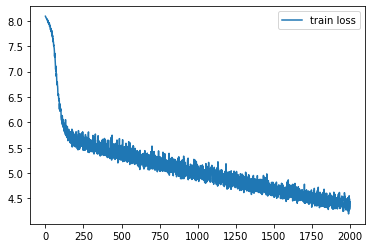

In [52]:
model = WordClassifier(rnn_num_units = 20).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

history = []
for i in range(2000):
    batch_ix = to_matrix([paragraphs[x] for x in random.sample(range(0, len(paragraphs)), 32)])
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    #loss = # YOUR CODE HERE
    loss = criterion(predictions_logp.contiguous().view(-1, len(vocabulary)), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i+1)%40==0:
        clear_output(True)
        with torch.no_grad():
            print(generate_sample(model, seed_phrase='love ', temperature=0.3))
        plt.plot(history,label='train loss')
        plt.legend()
        plt.show()
        
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [53]:
print(generate_sample(model, seed_phrase='me', temperature=0.4))

me , and my heart , and that is the world , and in me , and therefore but thy self , and all the shore , and in my face , and you , and true , and that i am i have , and for thy sweet


In [54]:
print(generate_sample(model, seed_phrase='me', temperature=1.6))

me free boldness have belongs ? of sue when foes asked in wherefore evil looking of thee knew is oblivion indeed lour'st , than our sins do but now monument in fortune's richer lame sin blame death , believe though speak despised physician niggard doubt to gives figur'd to


love <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


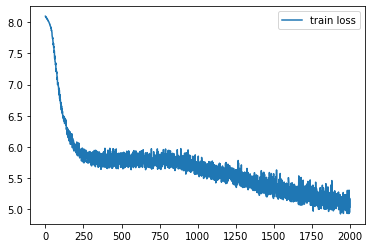

In [58]:
model = WordClassifier(rnn_num_units = 10, num_layers = 2).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

history = []
for i in range(2000):
    batch_ix = to_matrix([paragraphs[x] for x in random.sample(range(0, len(paragraphs)), 32)])
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    #loss = # YOUR CODE HERE
    loss = criterion(predictions_logp.contiguous().view(-1, len(vocabulary)), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i+1)%40==0:
        clear_output(True)
        with torch.no_grad():
            print(generate_sample(model, seed_phrase='love ', temperature=0.3))
        plt.plot(history,label='train loss')
        plt.legend()
        plt.show()
        
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [57]:
print(generate_sample(model, seed_phrase='love', temperature=1.))

love thou feed on your broad main , how who so love for my heart : i the best , whilst the anger thrusts into upon them moon and lusty , accumulate ; or made to invent of the bitterness of , do not in ' for


Выводы:
    герация по словам не очень зашла по двум возможным причинам 
    1) мало данных
    2) много уникальных слов
    
Зато можно заметить, что увеличение числа RNN/LSTM-слоев положительно сказалось на генерации:
    Кросс Энтропия упала больше на модели с большим числом слоев

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)